<a href="https://colab.research.google.com/github/Hbnyoni/CHEAQI-Dynamic-Indicators/blob/main/AOD_Mozambique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install geehydro
!pip install rioxarray
!apt install gdal-bin python3-gdal
!pip install fiona
!pip install rasterio
!pip install folium
!pip install geemap
!pip install cartopy
!pip install mapclassify
!pip install geoplot
!pip install pyreadr
!pip install pysal
!pip install contextily
!pip install jupyterlab
!pip install geopandas
!pip install pyreadr


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip
'apt' is not recognized as an internal or external command,
operable program or batch file.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
#import all libraries
import os
import geopandas as gpd
import numpy as np, pandas as pd
import ee
import geemap
import pyreadr
import matplotlib.pyplot as plt
from datetime import datetime
import geopandas as gpd
import requests
from io import BytesIO
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [9]:
# Authenticate and initialize Earth Engine API
try:
    ee.Initialize(project='ee-cheaqi')
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [10]:
# Check if notebook is running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
   IN_COLAB = False

In [11]:
if IN_COLAB:
    # Use the token from Github to clone the PRECISE repository with read/write access
    from IPython.display import clear_output; user="Hbnyoni"; token=input();
    !git clone https://github.com/Hbnyoni/dynamic_indicators.git

    clear_output()

ROI Bounding Box: [ 32.529671   -25.596207    32.964333   -24.86000923]
  district      admin_post      locality         name  neighborhood_code  \
0  MANHIÇA  3 DE FEVEREIRO       Taninga    4º Bairro             258018   
1  MANHIÇA         MALUANA  Maluana_sede       Pafene             258115   
2   MAGUDE          MAGUDE      CHICHUCO      Chicuco             258058   
3   MAGUDE          MAGUDE      MATCHABE  Bairro 2000             258031   
4   MAGUDE          MAGUDE    MAGUIGUANE      Bangane             258048   

                                            geometry  
0  MULTIPOLYGON (((32.8443 -25.1629, 32.84846 -25...  
1  MULTIPOLYGON (((32.65184 -25.54759, 32.65305 -...  
2  MULTIPOLYGON (((32.64127 -25.11344, 32.64141 -...  
3  MULTIPOLYGON (((32.67021 -25.01076, 32.66487 -...  
4  MULTIPOLYGON (((32.73317 -24.90993, 32.72411 -...  


C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:196: RuntimeWarning: File /vsimem/e0bce01871374d899a364013b283779a has GPKG application_id, but non conformant file extension
  return ogr_read(


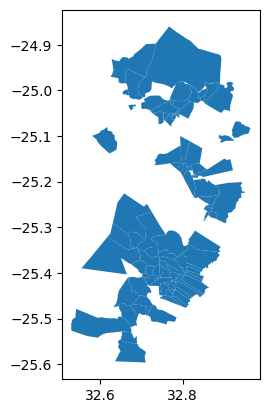

In [20]:
# GitHub raw URL for the GeoPackage (replace with your actual link)
url = 'https://github.com/Hbnyoni/dynamic_indicators/raw/main/shapefiles1/precise_villages.gpkg'

# Download the file using requests
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Read the file using geopandas from the bytes content
    with BytesIO(response.content) as f:
        gdf = gpd.read_file(f, layer='Mozambique')  # Update layer if necessary

    # Plot the geodataframe (optional)
    gdf.plot()

    # Get the bounding box of the shapefile
    bbox = gdf.total_bounds  # total_bounds returns [minx, miny, maxx, maxy]

    # Define the region of interest (ROI) as the bounding box of the shapefile
    roi = ee.Geometry.Rectangle([bbox[0], bbox[1], bbox[2], bbox[3]])

    # Print the bounding box for verification
    print(f"ROI Bounding Box: {bbox}")

else:
    print(f"Failed to download the file. Status code: {response.status_code}")

# Print the attribute table for reference (optional)
print(gdf.head())

In [16]:
import pyreadr

# Define the path to the RDS file
input_rds_path = 'C:/Users/user/OneDrive/Documents/CHEAQI-MNCH/CHEAQI Project Docs/VALIDATIN AND SEGMENTATION PRECISE DATASETS/Validation/Dynamic Indicators/AOD/Mozambique/outdoor_data.rds'

# Load the RDS file using pyreadr
result = pyreadr.read_r(input_rds_path)

# Extract the DataFrame (the object returned by pyreadr is a dictionary, we extract the first item)
outdoor_data = list(result.values())[0]

# Now 'outdoor_data' is a pandas DataFrame
# Assuming the datetime column is named 'date_time', convert it to datetime format
outdoor_data['date'] = pd.to_datetime(outdoor_data['date'], errors='coerce')

# Create a new column 'date_only' that contains only the date portion
outdoor_data['date_only'] = outdoor_data['date'].dt.strftime('%Y-%m-%d')

# Save the resulting dataframe to a CSV file
output_csv_path = 'C:/Users/user/OneDrive/Documents/CHEAQI-MNCH/CHEAQI Project Docs/VALIDATIN AND SEGMENTATION PRECISE DATASETS/Validation/Dynamic Indicators/AOD/Mozambique/Mozambique_with_date_only.csv'
outdoor_data.to_csv(output_csv_path, index=False)

print(f"Data with new 'date_only' column saved to {output_csv_path}")



Data with new 'date_only' column saved to C:/Users/user/OneDrive/Documents/CHEAQI-MNCH/CHEAQI Project Docs/VALIDATIN AND SEGMENTATION PRECISE DATASETS/Validation/Dynamic Indicators/AOD/Mozambique/Mozambique_with_date_only.csv


In [ ]:
## funtion to extract AOD Values ata same date using the lot lan
import ee
import pandas as pd
import numpy as np

# Initialize Earth Engine
ee.Initialize()

# Function to extract AOD values in batches
def extract_aod_values_batch(start_date, end_date, roi, points_df, batch_size=10000, aod_band='Optical_Depth_047'):
    """
    Extract AOD values from MODIS for a given region of interest (ROI) and date range in batches.

    Args:
    - start_date: Start date as a string in 'YYYY-MM-DD' format.
    - end_date: End date as a string in 'YYYY-MM-DD' format.
    - roi: Predefined region of interest (Earth Engine geometry object).
    - points_df: DataFrame with 'lat' and 'lon' columns representing the points of interest.
    - batch_size: Number of points to process in each batch.
    - aod_band: AOD band to extract, default is 'Optical_Depth_047'.

    Returns:
    - DataFrame with AOD values and corresponding dates for each point.
    """

    # Create an empty DataFrame to store results
    all_results = pd.DataFrame()

    # Split the points_df into batches
    num_batches = int(np.ceil(len(points_df) / batch_size))

    for batch_num in range(num_batches):
        # Extract the batch of points
        batch_df = points_df.iloc[batch_num * batch_size : (batch_num + 1) * batch_size]

        # Initialize a list to hold the batch results
        batch_results = []

        # Process each point in the batch
        for index, row in batch_df.iterrows():
            lon, lat = row['lon'], row['lat']
            point = ee.Geometry.Point([lon, lat])

            # Load the MODIS AOD collection and filter by the date range and point location
            modis_aod = ee.ImageCollection('MODIS/061/MCD19A2_GRANULES') \
                .select(aod_band) \
                .filterDate(start_date, end_date) \
                .filterBounds(point)

            # Get the list of images for the given point
            image_list = modis_aod.toList(modis_aod.size())

            # Extract AOD values for each image
            for i in range(image_list.size().getInfo()):
                img = ee.Image(image_list.get(i))
                date = img.date().format('YYYY-MM-dd').getInfo()

                # Reduce the image to the point to get the AOD value
                aod_value = img.reduceRegion(ee.Reducer.mean(), point, scale=500).get(aod_band).getInfo()

                # Append the result along with the date and AOD value
                batch_results.append({
                    'lat': lat,
                    'lon': lon,
                    'date_time': date,  # Original date time
                    'AOD_value': aod_value,
                    'date_only': date  # Adding date only column, already formatted as 'YYYY-MM-DD'
                })

        # Convert the batch results to a DataFrame
        batch_df_results = pd.DataFrame(batch_results)

        # Append the batch results to the overall results
        all_results = pd.concat([all_results, batch_df_results], ignore_index=True)

        print(f"Processed batch {batch_num + 1} of {num_batches}")

    return all_results

# Load the points of interest from the previous CSV
csv_path = 'C:/Users/user/OneDrive/Documents/CHEAQI-MNCH/CHEAQI Project Docs/VALIDATIN AND SEGMENTATION PRECISE DATASETS/Validation/Dynamic Indicators/AOD/Mozambique/Mozambique_with_date_only.csv'

# Use low_memory=False to handle mixed types warning, or specify dtype explicitly
points_df = pd.read_csv(csv_path, low_memory=False)

# You can also explicitly specify dtype if necessary:
# points_df = pd.read_csv(csv_path, dtype={'lat': 'float64', 'lon': 'float64'})

# Define the date range for the dataset (January 1, 2022 - January 31, 2023)
start_date = '2022-01-01'
end_date = '2023-01-31'

# Call the function to extract AOD values using the points from the previous CSV in larger batches
batch_size = 10000  # Set the batch size to 10,000 or more to handle large datasets
aod_results_df = extract_aod_values_batch(start_date, end_date, roi, points_df, batch_size=batch_size)

# Save the results to a CSV with 'date_only' included
aod_results_df.to_csv('aod_values_extracted_with_date_only.csv', index=False)

# Display the extracted results
print(aod_results_df)

